# Context
This notebook drives the training process for different models.

In [1]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [2]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [3]:
num_classes = 28
scores_path = os.path.join(sup.SCORES_ROOT, "specified", sup.TRAIN_KNN_CODE, f"PREPanalysis{num_classes}.csv")

top_barrier=2

## Helper functions

In [4]:
import math

def significance(row, score_col):
  C = int(row["num_classes"])
  score = row[score_col]

  k = 2 if score_col == 'top2accuracy' else 1
  if C == k:
    return 0
  
  # Chance the true class appears in a random top-k set:
  # Choose (k - 1) other classes from the remaining (C - 1), then divide by all
  # possible top-k sets
  # chance_score = math.comb(C - 1, k - 1)  /  math.comb(C, k)
  #       "      = ((C-1)! / ((C-1-(k-1))! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / ((C-k)! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / (k-1)!)  /  (C! / k!)
  #       "      = ((C-1)! / C!)  /  ((k-1)! / k!)
  #       "      = (k! / (k-1)!) / (C! / (C-1)!)
  #       "      = k / C
  # So:
  chance_score = k / C

  if score_col == 'accuracy' or score_col == 'top2accuracy':
    std = math.sqrt(chance_score * (1 - chance_score) / 100 * C)
  elif score_col == 'macro_recall':
    std = math.sqrt((1 - chance_score) / (100 * C**2))
  elif score_col == 'macro_precision':
    std = math.sqrt((C - 1) / (100 * C**2))

  z = (score - chance_score)/std

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
def visualize(df: pd.DataFrame, group_cols, top, filter_cols=None, filter_values=None, sortby='accuracy'):
  """
  Optionally filters df by filter_cols == filter_values, groups by group_cols,
  selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
  """
  filter_desc = ""

  # Optional filtering
  if filter_cols and filter_values:
    for col, val in zip(filter_cols, filter_values):
      df = df[df[col] == val]
    filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

  if df.empty:
    print("Warning: DataFrame is empty after filtering.")
    return

  # Group + mean of top k
  def top_k_mean(g):
    top_k = g.sort_values(f'{sortby}', ascending=False).head(top)
    if top_k.empty:
      return float('nan')  # or 0.0
    return top_k[f'{sortby}'].mean()

  mean_accuracies = (
      df.groupby(group_cols)
        .apply(top_k_mean)
        .to_frame(f'mean_{sortby}')
        .reset_index()
  )

  if mean_accuracies.empty:
    print("Warning: No data to plot after grouping.")
    return

  # Create labels
  mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

  # Plotting
  colors = sns.color_palette("muted", len(mean_accuracies))
  plt.figure(figsize=(10, 6))
  plt.bar(mean_accuracies['label'], mean_accuracies[f'mean_{sortby}'], color=colors)

  plt.ylabel(f"Mean Accuracy (Top {top})")
  plt.title(f"Top {top} Mean Accuracies per {' + '.join(group_cols)}{filter_desc}")
  plt.xticks(rotation=45, ha='right')

  # Add y-limit padding
  min_val = mean_accuracies[f'mean_{sortby}'].min()
  max_val = mean_accuracies[f'mean_{sortby}'].max()
  padding = (max_val - min_val) * 0.3 if max_val > min_val else 0.1
  plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

  # Add value labels
  for i, val in enumerate(mean_accuracies[f'mean_{sortby}']):
    plt.text(i, val + padding * 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()



## Data

In [7]:
knn_scores_df = pd.read_csv(scores_path)
knn_scores_df.sort_values(by="top2accuracy", ascending=False)

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
0,Spf,False,2,easy,0.998081,1.000000,0.998080,0.998120,0.998047
81,Spf,True,2,easy,0.982726,1.000000,0.982713,0.983053,0.982555
245,Spv,True,2,hard,0.860465,1.000000,0.860390,0.866304,0.869518
244,Spv,True,2,average,1.000000,1.000000,1.000000,1.000000,1.000000
243,Spv,True,2,easy,0.954545,1.000000,0.949425,0.937500,0.966667
...,...,...,...,...,...,...,...,...,...
232,Spv,False,25,average,0.621032,0.067460,0.614145,0.634166,0.611320
314,Spv,True,25,hard,0.529762,0.063492,0.529322,0.545345,0.530629
233,Spv,False,25,hard,0.623016,0.063492,0.629650,0.649464,0.628467
304,Spv,True,22,average,0.514739,0.061224,0.512377,0.527234,0.516342


In [8]:
for metric_name in ['accuracy', 'top2accuracy', 'macro_precision', 'macro_recall']:
  knn_scores_df[f'{metric_name}_z'] = knn_scores_df.apply(lambda x: significance(x, metric_name), axis=1)

knn_scores_df['harmonic_z'] = knn_scores_df.apply(harmonic_z, axis=1)

knn_scores_df

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z,top2accuracy_z,macro_precision_z,macro_recall_z,harmonic_z
0,Spf,False,2,easy,0.998081,1.000000,0.998080,0.998120,0.998047,7.043924,0.000000,9.962406,14.086893,11.670972
1,Spf,False,2,average,1.000000,1.000000,1.000000,1.000000,1.000000,7.071068,0.000000,10.000000,14.142136,11.715729
2,Spf,False,2,hard,0.968442,1.000000,0.968439,0.968465,0.968684,6.624768,0.000000,9.369301,13.256381,10.978942
3,Spf,False,3,easy,0.994778,0.669713,0.995052,0.994913,0.995210,8.101010,0.037307,14.034223,24.318911,17.797608
4,Spf,False,3,average,0.993261,0.675202,0.993382,0.993743,0.993054,8.082436,0.104538,14.009412,24.239692,17.756433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,Spv,True,27,average,0.486289,0.076782,0.490595,0.514330,0.491792,4.578098,0.019902,25.273333,125.122767,42.052544
320,Spv,True,27,hard,0.480874,0.080146,0.476120,0.493066,0.480500,4.522921,0.044617,24.147358,122.015769,40.316030
321,Spv,True,28,easy,0.482394,0.077465,0.473899,0.510643,0.485450,4.548767,0.044294,25.592039,128.236796,42.668737
322,Spv,True,28,average,0.482394,0.077465,0.473899,0.510643,0.485450,4.548767,0.044294,25.592039,128.236796,42.668737


### Inital number-of-classes-agnostic analysis

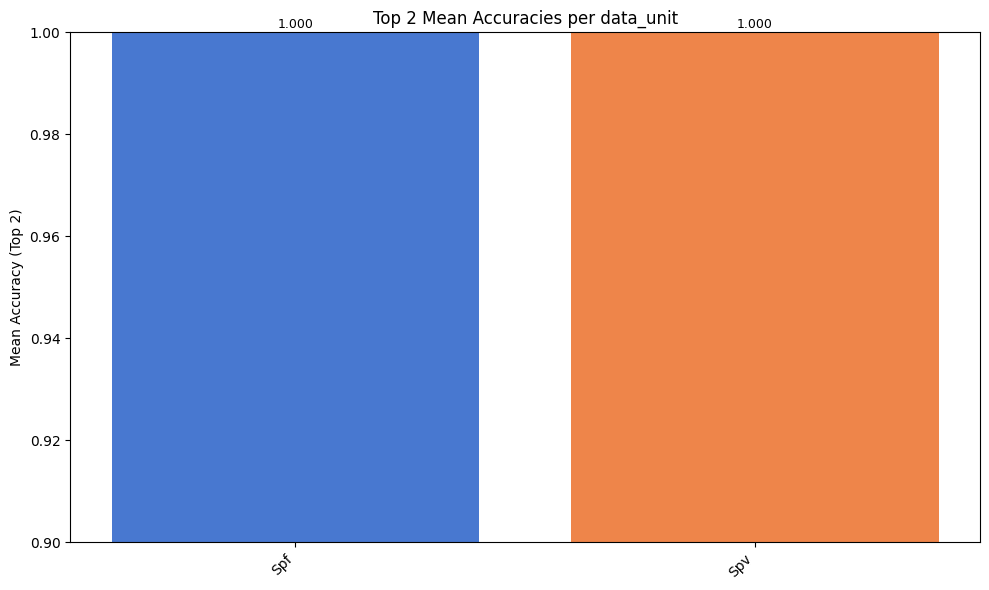

In [9]:
visualize(knn_scores_df, group_cols=['data_unit'], top=top_barrier)

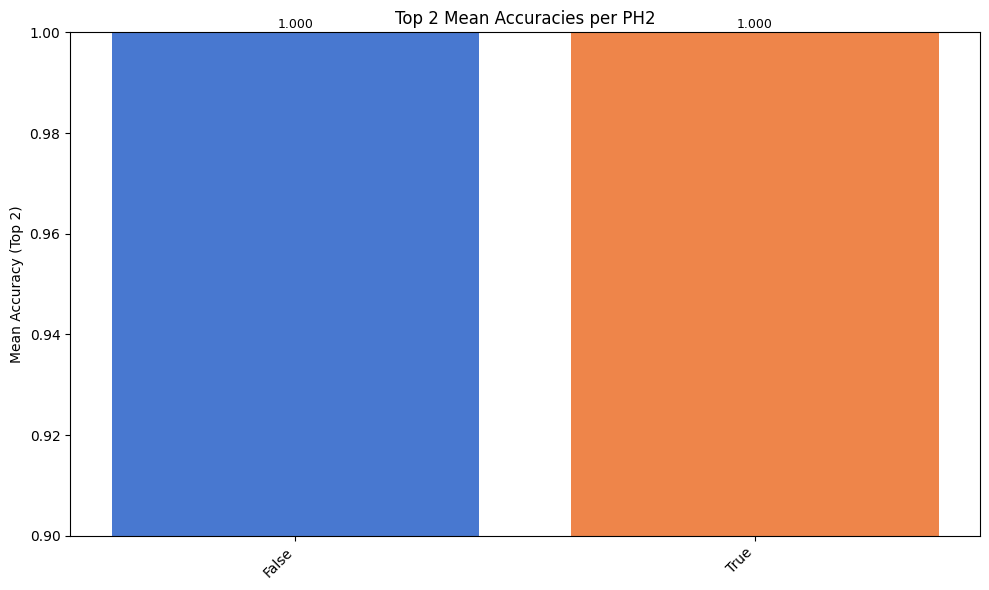

In [10]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier)

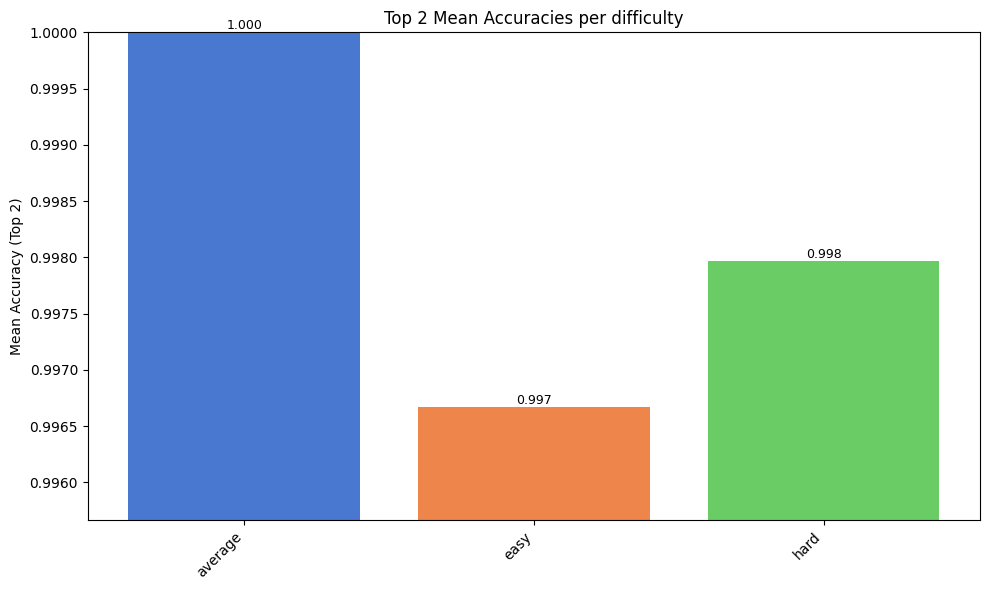

In [11]:
visualize(knn_scores_df, group_cols=['difficulty'], top=top_barrier, sortby='accuracy')

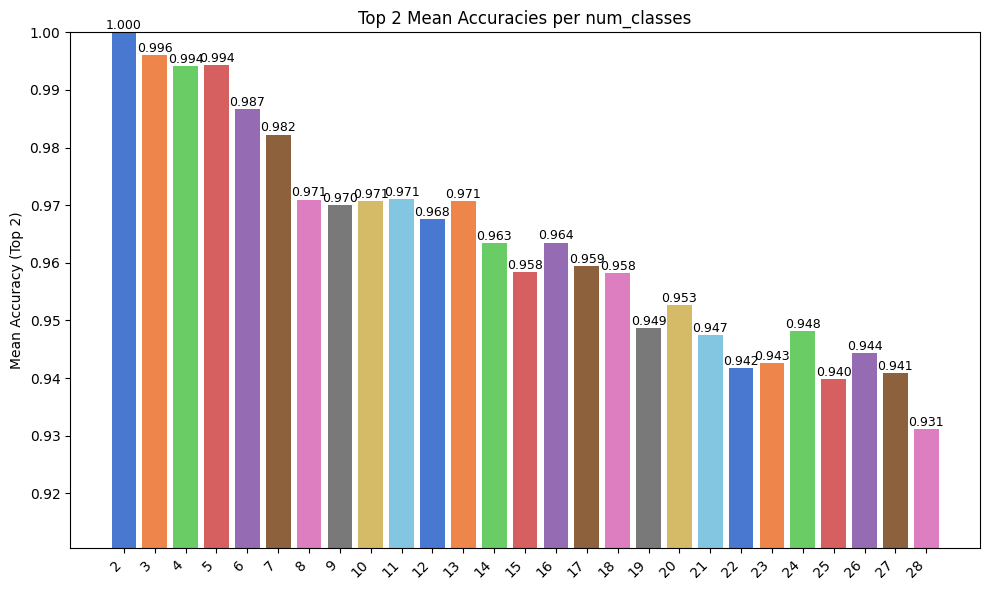

In [12]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier)

### Intial analysis compensanting for number of classes

#### data_unit

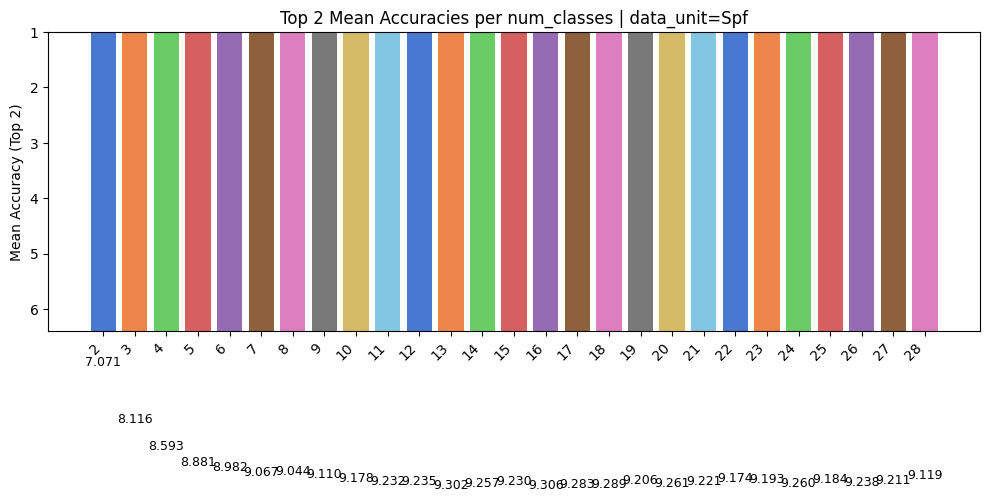

In [13]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='accuracy_z')

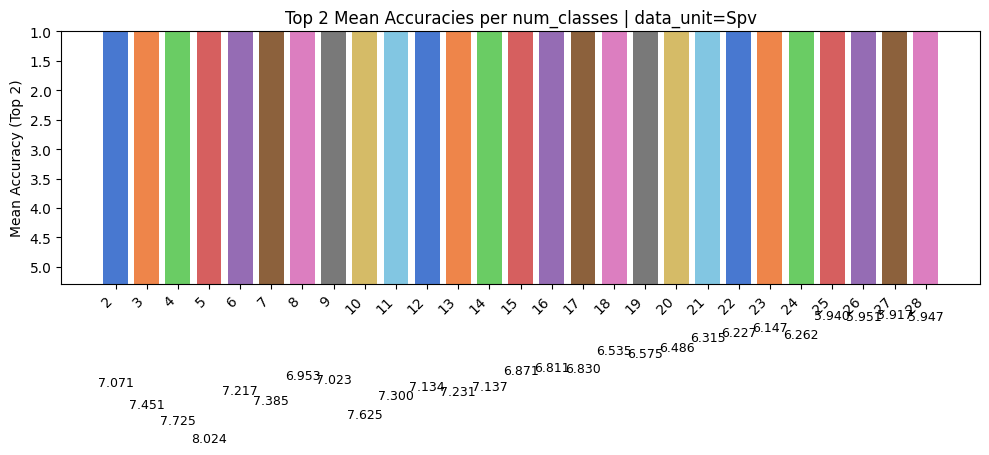

In [14]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='accuracy_z')

#### PH2

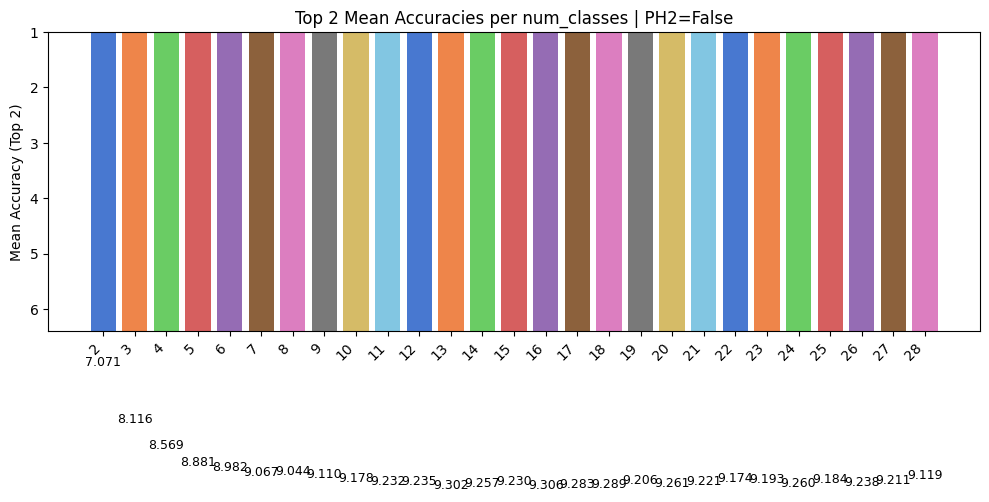

In [15]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='accuracy_z')

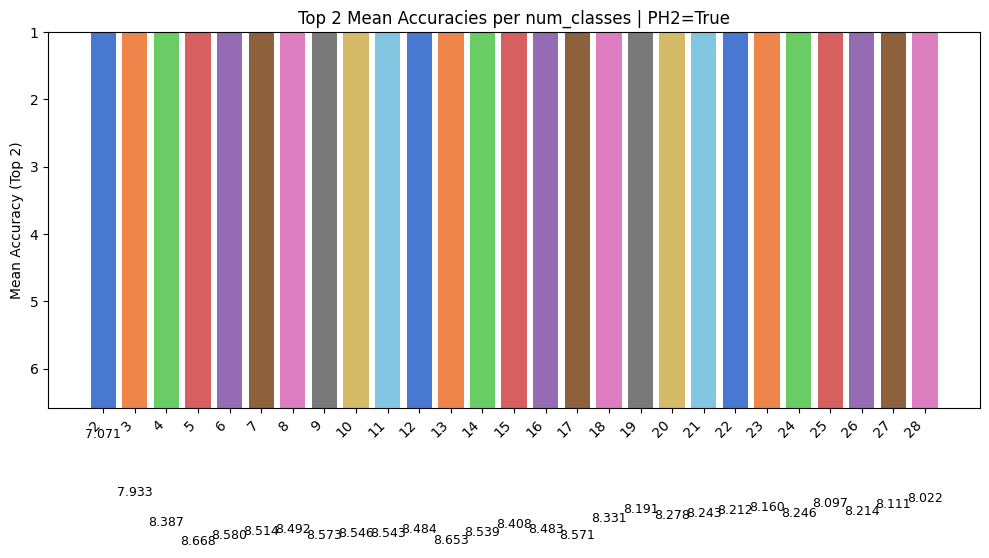

In [16]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='accuracy_z')

#### difficulty

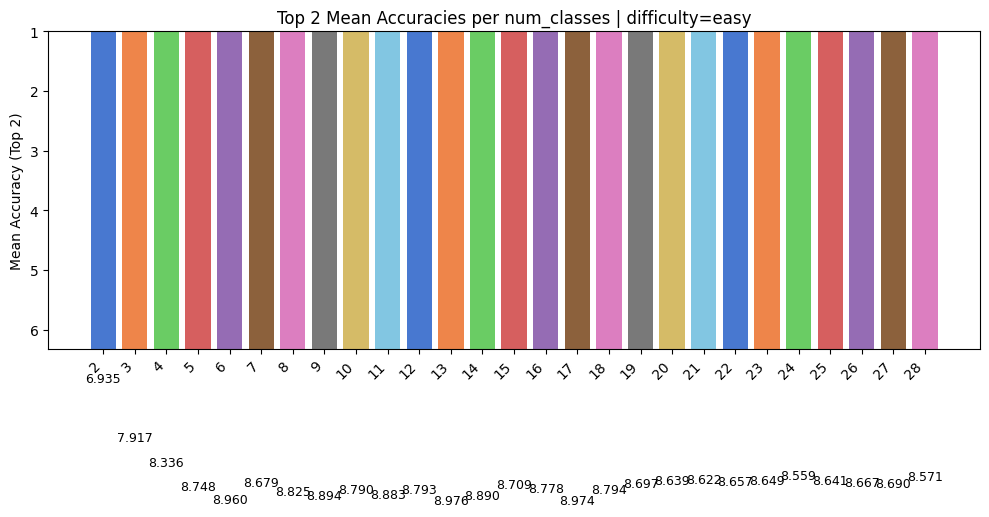

In [17]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='accuracy_z')

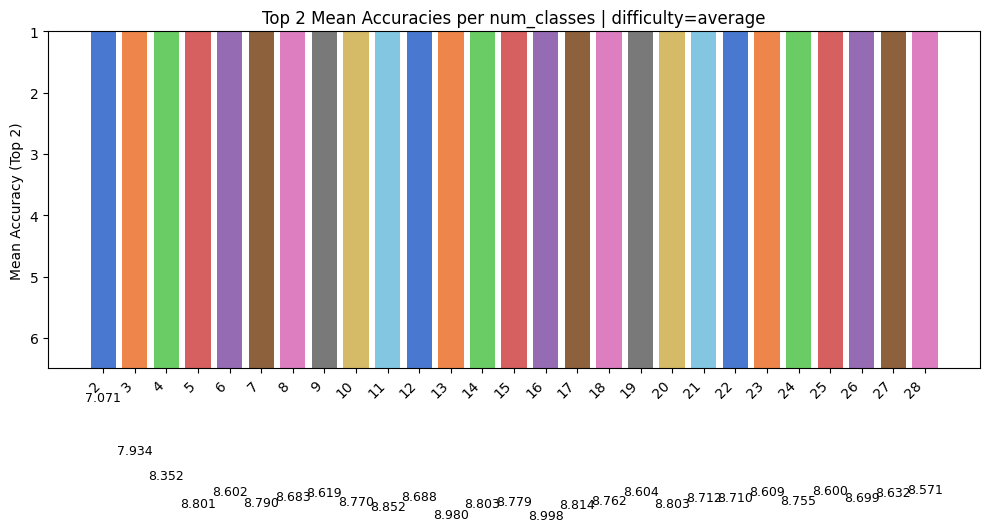

In [18]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='accuracy_z')

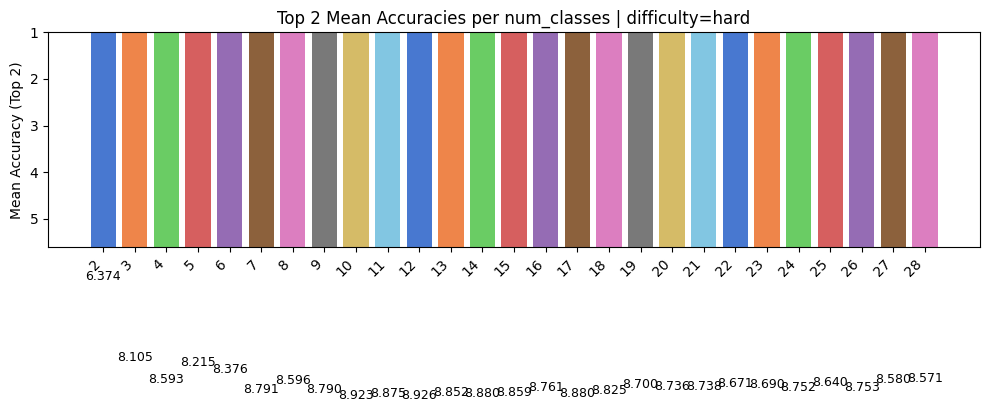

In [19]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='accuracy_z')

### Same but with harmonization of significance or recall and precision

#### data_unit

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


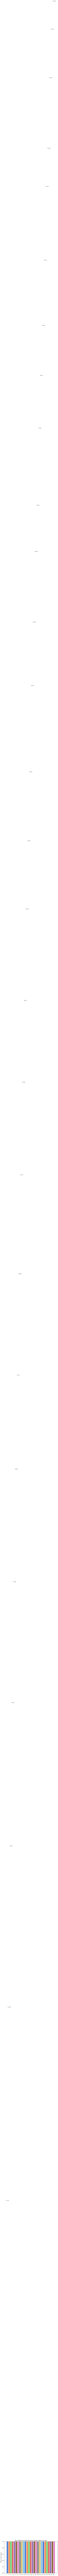

In [20]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='harmonic_z')

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


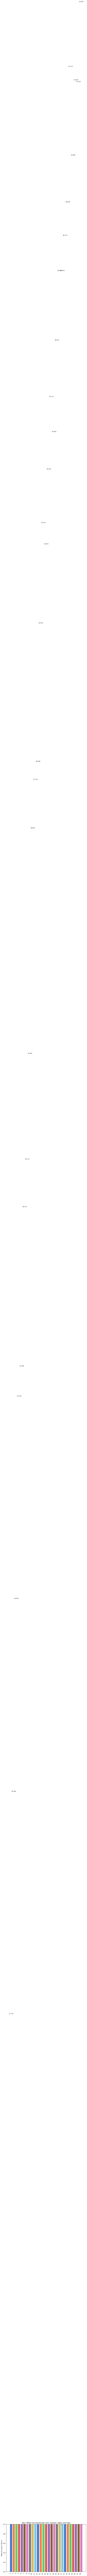

In [21]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='harmonic_z')

#### PH2

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


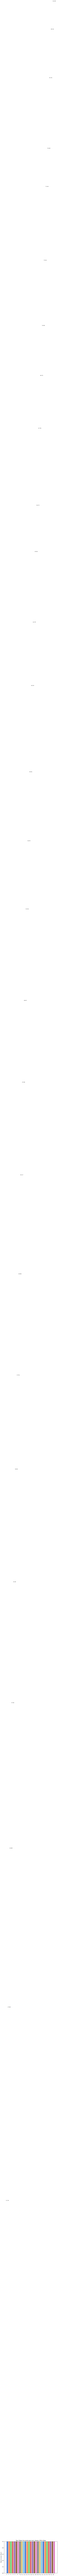

In [22]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='harmonic_z')

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


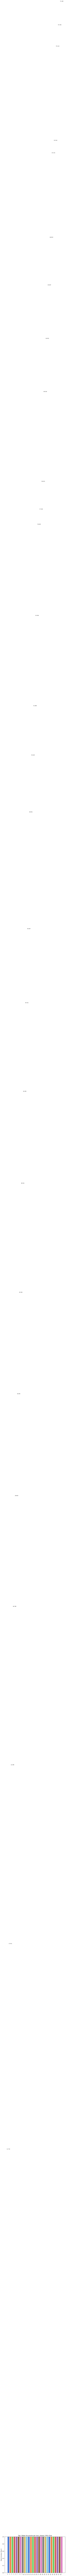

In [23]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='harmonic_z')

#### difficulty

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


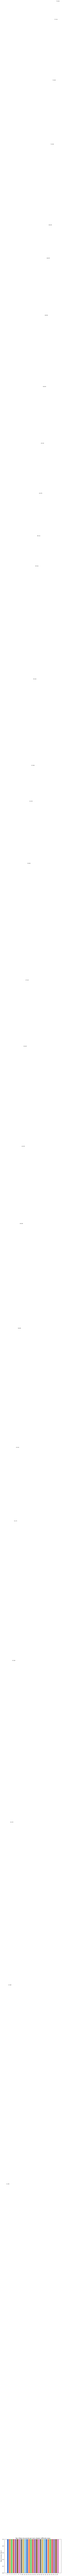

In [24]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='harmonic_z')

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


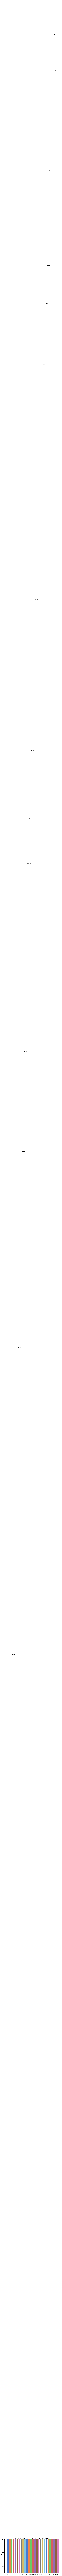

In [25]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='harmonic_z')

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_20888/3225647315.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


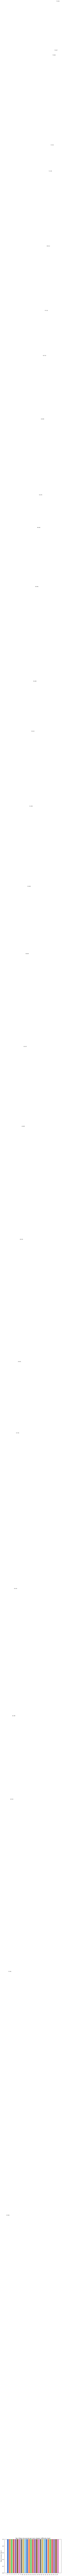

In [26]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='harmonic_z')